### Setup inicial

In [1]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BDeu, BayesianEstimator, BIC
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.metrics import BayesianModelProbability

import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import KFold
from tqdm import tqdm
import os

# Configuración general
np.random.seed(42)
pd.set_option("display.max_columns", None)

DATA_PATH = "../eleven_nodes/tv_bn_dataset.csv"
N_SPLITS = 5
EQUIVALENT_SAMPLE_SIZE = 200
MAX_INDEGREE = 3


/home/carlosbravo/Documents/MasOrange/Code/BN_Film_Recommender/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cargar datos

In [2]:
df = pd.read_csv(DATA_PATH)
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")
df.head()


Dataset cargado con 10000 filas y 11 columnas.


,GeneroUsuario,EdadUsuario,Hora,DiaSemana,DuracionPrograma,TipoEmision,InteresPrevio,GeneroPrograma,PopularidadPrograma,Satisfaccion,Recomendado
0,hombre,joven,noche,laboral,corta,bajo_demanda,noticias,noticias,baja,media,sí
1,hombre,mayor,mañana,laboral,corta,diferido,noticias,entretenimiento,alta,baja,no
2,hombre,adulto,tarde,fin_semana,corta,bajo_demanda,noticias,noticias,baja,alta,no
3,mujer,adulto,tarde,laboral,corta,directo,película,película,baja,alta,no
4,hombre,joven,tarde,laboral,corta,directo,entretenimiento,noticias,baja,alta,no


### Funciones auxiliares

#### Guardar nodos y arcos

In [3]:
def save_edges_to_csv(model, folder, filename="edges_final.csv"):
    """Guarda los arcos del modelo en un CSV."""
    os.makedirs(folder, exist_ok=True)
    with open(os.path.join(folder, filename), "w", encoding="utf-8") as f:
        f.write("source,target\n")
        for u, v in model.edges():
            f.write(f"{u},{v}\n")



#### Guardar CPDs

In [4]:
def save_cpds_to_txt(model, folder, filename="cpds_final.txt"):
    """Guarda las CPDs (tablas de probabilidad) en un archivo de texto."""
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, filename)
    with open(path, "w", encoding="utf-8") as f:
        f.write(f"Tablas de probabilidad condicional - Modelo final\n")
        f.write("=" * 80 + "\n\n")
        for cpd in model.get_cpds():
            f.write(f"CPD de {cpd.variable}:\n")
            f.write(str(cpd))
            f.write("\n" + "-" * 80 + "\n")
    print(f"CPDs guardadas en: {path}")

def save_cpds_to_csv(model, folder):
    """Guarda cada CPD del modelo como un CSV completo (sin truncar)."""
    os.makedirs(os.path.join(folder, "cpds_csv"), exist_ok=True)
    for cpd in model.get_cpds():
        var = cpd.variable
        states = cpd.state_names[var]
        parents = list(cpd.variables[1:])

        # Construir todas las combinaciones de valores de los padres
        if parents:
            import itertools
            parent_states = [cpd.state_names[p] for p in parents]
            combinations = list(itertools.product(*parent_states))
            records = []
            for combo, probs in zip(combinations, cpd.values.T):
                for s, p in zip(states, probs):
                    row = {parents[i]: combo[i] for i in range(len(parents))}
                    row[var] = s
                    row["P"] = p
                    records.append(row)
            df_cpd = pd.DataFrame(records)
        else:
            df_cpd = pd.DataFrame({
                var: states,
                "P": cpd.values
            })

        path = os.path.join(folder, "cpds_csv", f"CPD_{var}.csv")
        df_cpd.to_csv(path, index=False)
    print(f"CPDs completas guardadas en '{folder}/cpds_csv/'")


#### Crear grafo

In [5]:
def visualize_model(model, title="Red Bayesiana aprendida"):
    """Dibuja el grafo de la red aprendida."""
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True,
        node_size=1000, node_color="skyblue",
        font_size=10, arrowsize=20, edgecolors="black"
    )
    plt.title(title, fontsize=14)
    plt.show()


#### Entrenamiento y evaluación

In [6]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, balanced_accuracy_score
from pgmpy.inference import VariableElimination

def evaluate_bn_classifier_cv(df, target="Recomendado", n_splits=N_SPLITS, max_indegree=MAX_INDEGREE, ess=EQUIVALENT_SAMPLE_SIZE, output_folder="bn_classifier_results"):
    """Evalúa la red bayesiana como clasificador (prediciendo 'target') mediante K-Fold CV."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    acc_scores, bal_acc_scores, rec_scores, f1_scores = [], [], [], []
    final_model = None

    for fold, (train_idx, test_idx) in enumerate(tqdm(kf.split(df), total=n_splits, desc="K-Fold CV"), 1):
        train, test = df.iloc[train_idx], df.iloc[test_idx]

        # Aprendizaje de estructura
        hc = HillClimbSearch(train)
        best_model = hc.estimate(scoring_method=BDeu(train, equivalent_sample_size=ess), max_indegree=max_indegree)

        # Ajuste de CPDs
        model = DiscreteBayesianNetwork(best_model.edges())
        model.fit(train, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=ess)

        # Inferencia predictiva
        infer = VariableElimination(model)
        y_true, y_pred = [], []

        test_sample = test.sample(n=min(1000, len(test)), random_state=fold)

        for _, row in test_sample.iterrows():
            evidence = {col: row[col] for col in df.columns if col != target}
            try:
                pred = infer.map_query(variables=[target], evidence=evidence)
                y_pred.append(pred[target])
                y_true.append(row[target])
            except Exception:
                y_pred.append(train[target].mode()[0])
                y_true.append(row[target])

        # Métricas
        acc = accuracy_score(y_true, y_pred)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred, average="macro")
        f1 = f1_score(y_true, y_pred, average="macro")

        acc_scores.append(acc)
        bal_acc_scores.append(bal_acc)
        rec_scores.append(rec)
        f1_scores.append(f1)

        if fold == n_splits:
            final_model = model

    # Resultados medios
    results = {
        "accuracy_mean": np.mean(acc_scores),
        "balanced_accuracy_mean": np.mean(bal_acc_scores),
        "recall_mean": np.mean(rec_scores),
        "f1_mean": np.mean(f1_scores)
    }

    os.makedirs(output_folder, exist_ok=True)
    pd.DataFrame([results]).to_csv(os.path.join(output_folder, "summary_scores.csv"), index=False)

    # Guardar red y CPDs finales
    save_edges_to_csv(final_model, output_folder)
    save_cpds_to_txt(final_model, output_folder)
    save_cpds_to_csv(final_model, output_folder)
    visualize_model(final_model, title=f"Red Bayesiana final (clasificador '{target}')")

    print(f"Resultados guardados en '{output_folder}/summary_scores.csv'")
    return results


### CV

K-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'PopularidadPrograma': 'C', 'Satisfaccion': 'C', 'Recomendado': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GeneroUsuario': 'C', 'EdadUsuario': 'C', 'Hora': 'C', 'DiaSemana': 'C', 'DuracionPrograma': 'C', 'TipoEmision': 'C', 'InteresPrevio': 'C', 'GeneroPrograma': 'C', 'Popula

CPDs guardadas en: bn_classifier_results/cpds_final.txt
CPDs completas guardadas en 'bn_classifier_results/cpds_csv/'


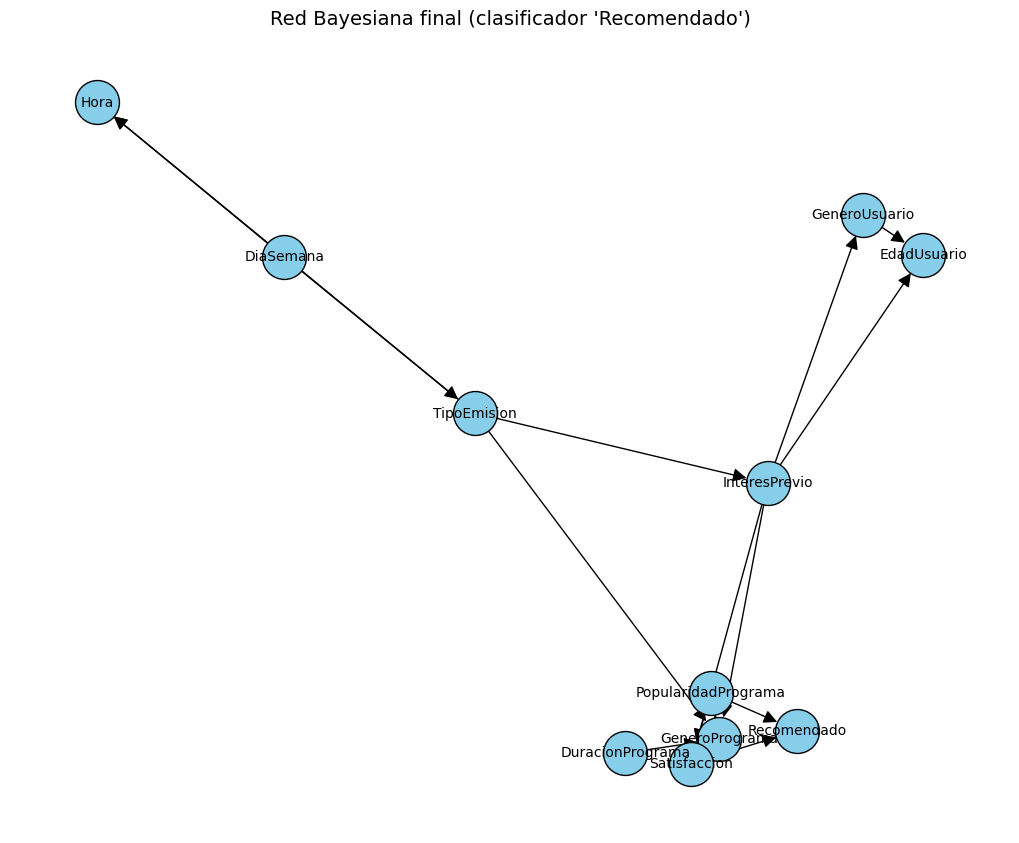

Resultados guardados en 'bn_classifier_results/summary_scores.csv'

Resultados Cross-Validation (Clasificador Bayesiano)
Accuracy:           0.788
Balanced Accuracy:  0.710
Recall:             0.710
F1-score:           0.726


In [7]:
# Evaluación
results = evaluate_bn_classifier_cv(
    df,
    target="Recomendado",
    n_splits=N_SPLITS,
    max_indegree=MAX_INDEGREE,
    ess=EQUIVALENT_SAMPLE_SIZE
)

### Resultados
print("\nResultados Cross-Validation (Clasificador Bayesiano)")
print(f"Accuracy:           {results['accuracy_mean']:.3f}")
print(f"Balanced Accuracy:  {results['balanced_accuracy_mean']:.3f}")
print(f"Recall:             {results['recall_mean']:.3f}")
print(f"F1-score:           {results['f1_mean']:.3f}")